# This notebook demos the FVM laplacian

Compute the Laplacian using combinations of the differential operators encountered so far

In [37]:
from dusk.script import *


@stencil
def laplacian_fvm(
    u: Field[Edge], 
    v: Field[Edge], 
    nx: Field[Edge], 
    ny: Field[Edge],
    uv_div: Field[Cell],
    uv_curl: Field[Vertex],
    grad_of_curl: Field[Edge],
    grad_of_div: Field[Edge],
    uv_nabla2: Field[Edge],
    L: Field[Edge],
    dualL: Field[Edge],
    A: Field[Cell],
    dualA: Field[Vertex],
    tangent_orientation: Field[Edge],
    edge_orientation_vertex: Field[Vertex > Edge],
    edge_orientation_cell: Field[Cell > Edge],
) -> None:

    with levels_upward as k:

        # compute curl (on vertices)
        uv_curl = sum_over(Vertex > Edge, (u*nx + v*ny) * dualL * edge_orientation_vertex) / dualA

        # compute divergence (on cells)
        uv_div = sum_over(Cell > Edge, (u*nx + v*ny) * L * edge_orientation_cell) / A

        # first term of of nabla2 (gradient of curl)
        grad_of_curl = sum_over(Edge > Vertex, uv_curl, weights=[-1., 1, ])*tangent_orientation/L        

        # second term of of nabla2 (gradient of divergence)
        grad_of_div = sum_over(Edge > Cell, uv_div, weights=[-1., 1, ])*tangent_orientation/dualL        

        # finalize nabla2 (difference between the two gradients)
        uv_nabla2 = grad_of_div - grad_of_curl


Then we can use dusk's Python API to convert the stencils to SIR. This API can also invoke dawn to compile SIR to C++:

In [38]:
from dusk.transpile import callables_to_pyast, pyast_to_sir, sir_to_cpp

with open("laplacian_fvm_cxx-naive.cpp", "w+") as f:
    f.write(sir_to_cpp(pyast_to_sir(callables_to_pyast([laplacian_fvm]))))

The generated C++ code also requires a driver which is already setup for this demo. With the driver code we can generate an executable `runner`:

In [48]:
!make

Now, its up to you which differentail operator you want to run and check. Simply launch `runner gradient`, `runner divergence` or `runner curl`

In [49]:
!./runner 

mesh stats: #cells 1760 #nodes 940 #edges 2699


Besides ensuring the error norms L1, L2 and L infinity are small (they should all be well below 0.1), you can also have a look at some test functions and their differentials. Again, you can use `check gradient`, `check divergence` or `check curl`. Please make sure that you ran the appropriate differential operator beforhand using the `runner`

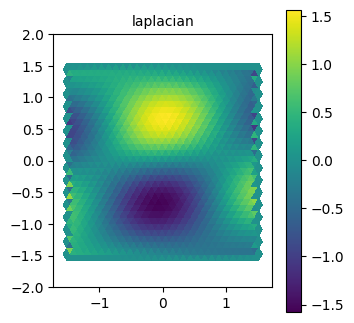

In [50]:
%run checker.py laplacian